# Lab 03: Logistic Regression

Thus far, the problems we've encountered have been *regression* problems, in which the target $y \in \mathbb{R}$.

Today we'll start experimenting with *classification* problems, beginning with *binary* classification problems, in which the target $y \in \{ 0, 1 \}$.

## Background

The simplest approach to classification, applicable when the input feature vector $\mathbf{x} \in \mathbb{R}^n$, is a simple generalization of what we
do in linear regression. Recall that in linear regression, we assume that the target is drawn from a Gaussian distribution whose mean is a linear function
of $\mathbf{x}$:

$$ y \sim {\cal N}(\theta^\top \mathbf{x}, \sigma^2) $$

In logistic regression, similarly, we'll assume that the target is drawn from a Bernoulli distribution with parameter $p$ being the probability of
class 1:

$$ y \sim \text{Bernoulli}(p) $$

That's fine, but how do we model the parameter $p$? How is it related to $\mathbf{x}$?

In linear regression, we assume that the mean of the Gaussian is $\theta^\top \mathbf{x}$, i.e., a linear function of $\mathbf{x}$.

In logistic regression, we'll assume that $p$ is a "squashed" linear function of $\mathbf{x}$, i.e.,

$$ p = \text{sigmoid}(\theta^\top \mathbf{x}) = g(\theta^\top \mathbf{x}) = \frac{1}{1+e^{-\theta^\top \mathbf{x}}}. $$

Later, when we introduce generalized linear models, we'll see why $p$ should take this form. For now, though, we can simply note that the selection makes
sense. Since $p$ is a discrete probability, $p$ is bounded by $0 \le p \le 1$. The sigmoid function $g(\cdot)$ conveniently obeys these bounds:


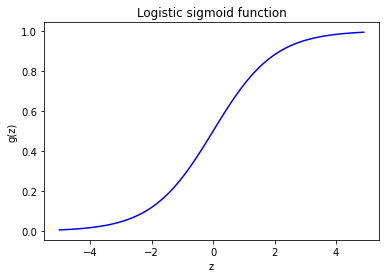

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def f(z):
    return 1 / (1 + np.exp( -z ))

z = np.arange(-5, 5, 0.1)
plt.plot(z, f(z), 'b-')
plt.xlabel('z')
plt.ylabel('g(z)')
plt.title('Logistic sigmoid function')
plt.show()

We see that the sigmoid approaches 0 as its input approaches $-\infty$ and approaches 1 as its input approaches $+\infty$. If its input is 0, its value is 0.5.

Again, this choice of function may seem strange at this point, but bear with it! We'll derive this function from a more general principle, the generalized
linear model, later.

OK then, we now understand that for logistic regression, the assumptions are:

1. The *data* are pairs $(\textbf{x}, y) \in \mathbb{R}^n \times \{ 0, 1 \}$.
1. The *hypothesis function* is $h_\theta(\textbf{x}) = \frac{1}{1+e^{-\theta^\top \mathbf{x}}}$.

What else do we need... ? A cost function and an algorithm for minimizing that cost function!

## Cost function for logistic regression

You can refer to the lecture notes to see the derivation, but for this lab, let's just skip to the chase.
With the hypothesis $h_\theta(\mathbf{x})$ chosen as above, the log likelihood function $\ell(\theta)$ can be derived as
$$ \ell(\theta) = \log {\cal L}(\theta) =  \sum_{i=1}^{m}y^{(i)}\log(h_{\theta}(\mathbf{x}^{(i)})) + (1 - y^{(i)})\log(1 - (h_{\theta}(\mathbf{x}^{(i)})) .$$

Negating the log likelihood function to obtain a loss function, we have

$$ J(\theta) = - \sum_{i=1}^m y^{(i)}\log h_\theta(\mathbf{x}^{(i)}) + (1-y^{(i)})\log(1-h_\theta(\textbf{x}^{(i)})) .$$

There is no closed-form solution to this problem like there is in linear regression, so we have to use gradient descent to find $\theta$ minimizing $J(\theta)$.
Luckily, the function *is* convex in $\theta$ so there is just a single global minimum, and gradient descent is guaranteed to get us there eventually if we take
the right step size.

The *stochastic* gradient of $J$, for a single observed pair $(\mathbf{x}, y)$, turns out to be (see lecture notes)

$$\nabla_J(\theta) = (h_\theta(\mathbf{x}) - y)\mathbf{x} .$$

Give some thought as to whether following this gradient to increase the loss $J$ would make a worse classifier, and vice versa!

Finally, we obtain the update rule for the $j$th iteration selecting training pattern $i$:

$$ \theta^{(j+1)} \leftarrow \theta^{(j)} + \alpha(y^{(i)} - h_\theta(\textbf{x}^{(i)}))\textbf{x}^{(i)} .$$ 

Note that we can perform *batch gradient descent* simply by summing the single-pair gradient over the entire training set before taking a step,
or *mini-batch gradient descent* by summing over a small subset of the data.

## Example dataset 1: student admissions data

This example is from Andrew Ng's machine learning course on Coursera.

The data contain students' scores for two standardized tests and an admission decision (0 or 1).


In [2]:

# Load student admissions data. The data file does not contain headers,
# so we use hard coded indices for exam 1, exam2, and the admission decision.

data = np.loadtxt('ex2data1.txt',delimiter = ',')
exam1_data = data[:,0]
exam2_data = data[:,1]
X = np.array([exam1_data, exam2_data]).T
y = data[:,2]

# Output some sample data

print('Exam scores', X[0:5,:])
print('-----------------------------')
print('Admission decision', y[0:5])


Exam scores [[34.62365962 78.02469282]
 [30.28671077 43.89499752]
 [35.84740877 72.90219803]
 [60.18259939 86.3085521 ]
 [79.03273605 75.34437644]]
-----------------------------
Admission decision [0. 0. 0. 1. 1.]


Let's plot the data...

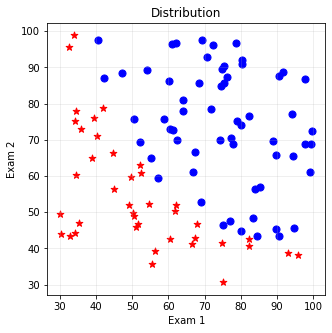

In [3]:
# Plot the data

idx_0 = np.where(y == 0)
idx_1 = np.where(y == 1)

fig1 = plt.figure(figsize=(5, 5)) 
ax = plt.axes()
ax.set_aspect(aspect = 'equal', adjustable = 'box')
plt.title('Distribution')
plt.xlabel('Exam 1')
plt.ylabel('Exam 2')
plt.grid(axis='both', alpha=.25)
ax.scatter(exam1_data[idx_0], exam2_data[idx_0], s=50, c='r', marker='*', label='Not Admitted')
ax.scatter(exam1_data[idx_1], exam2_data[idx_1], s=50, c='b', marker='o', label='Admitted')
plt.show()


Let's see if we can find good values for $\theta$ without normalizing the data.
We will definitely want to split the data into train and test, however...

In [4]:
import random

# Partion data into training and test datasets

m, n = X.shape
XX = np.insert(X, 0, 1, axis=1)
y = y.reshape(m, 1)
idx = np.arange(0, m)
random.shuffle(idx)
percent_train = .6
m_train = int(m * percent_train)
train_idx = idx[0:m_train]
test_idx = idx[m_train:]
X_train = XX[train_idx,:];
X_test = XX[test_idx,:];

y_train = y[train_idx];
y_test = y[test_idx];
 
theta_initial = np.zeros((n+1, 1))


In [5]:
def sigmoid(z):   
    return 1 / (1 + np.exp(-z))

def h(X, theta):
    return sigmoid(X @ theta)

def grad_j(X, y, y_pred):
    return X.T @ (y - y_pred) / X.shape[0]
    
def j(theta, X, y):    
    y_pred = h(X, theta)
    error = (-y * np.log(y_pred)) - ((1 - y) * np.log(1 - y_pred))
    cost = sum(error) / X.shape[0]
    grad = grad_j(X, y, y_pred)
    return cost[0], grad


In [6]:
# Get a feel for how h works

print('Initial theta:', theta_initial)
print('Initial predictions:', h(XX, theta_initial)[0:5,:])
print('Targets:', y[0:5,:])


Initial theta: [[0.]
 [0.]
 [0.]]
Initial predictions: [[0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]]
Targets: [[0.]
 [0.]
 [0.]
 [1.]
 [1.]]


In [7]:
# Batch training for num_iters iterations

def train(X, y, theta_initial, alpha, num_iters):
    theta = theta_initial
    j_history = []
    for i in range(num_iters):
        cost, grad = j(theta, X, y)
        theta = theta + alpha * grad
        j_history.append(cost)
    return theta, j_history


Theta optimized: [[-11.2247375 ]
 [  0.09192793]
 [  0.0938473 ]]
Cost with optimized theta: 0.3010983841989376


Text(0.5, 1.0, 'Training cost over time with batch gradient descent (no normalization)')

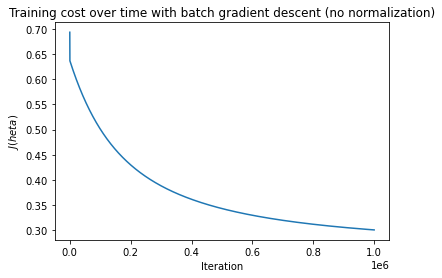

In [8]:
# Train for 3000 iterations on full training set

alpha = .0005
num_iters = 1000000
theta, j_history = train(X_train, y_train, theta_initial, alpha, num_iters)

print("Theta optimized:", theta)
print("Cost with optimized theta:", j_history[-1])

plt.plot(j_history)
plt.xlabel("Iteration")
plt.ylabel("$J(\theta)$")
plt.title("Training cost over time with batch gradient descent (no normalization)")


### In-lab exercise

That took a long time, right?

See if you can do better. Try increasing the learning rate $\alpha$ and starting with a better initial $\theta$. How much does it help?

Better yet, try *normalizing the data* and see if the training converges better. How did it go? Discuss the effects of normalization, learning rate, and
initial $\theta$ in your report.




### Decision boundary

Note that when $\theta^\top \textbf{x} = 0$, we have $h_\theta(\textbf{x}) = 0.5$. That is, we are
equally unsure as to whether $\textbf{x}$ belongs to class 0 or class 1. The contour at which
$h_\theta(\textbf{x}) = 0.5$ is called the classifier's *decision boundary*.

We know that in the plane, the equation $$ax+by+c=0$$ is the general form of a 2D line. In our case, we have
$$\theta_0 + \theta_1 x_1 + \theta_2 x_2 = 0$$ as our decision boundary, but clearly, this is just a 2D line
in the plane. So when we plot $x_1$ against $x_2$, it is easy to plot the boundary line.

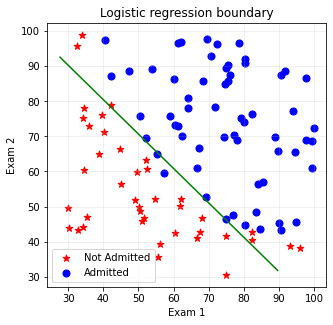

In [9]:
def boundary_points(X, theta):
    v_orthogonal = np.array([[theta[1,0]],[theta[2,0]]])
    v_ortho_length = np.sqrt(v_orthogonal.T @ v_orthogonal)
    dist_ortho = theta[0,0] / v_ortho_length
    v_orthogonal = v_orthogonal / v_ortho_length
    v_parallel = np.array([[-v_orthogonal[1,0]],[v_orthogonal[0,0]]])
    projections = X @ v_parallel
    proj_1 = min(projections)
    proj_2 = max(projections)
    point_1 = proj_1 * v_parallel - dist_ortho * v_orthogonal
    point_2 = proj_2 * v_parallel - dist_ortho * v_orthogonal
    return point_1, point_2

fig1 = plt.figure(figsize=(5,5)) 
ax = plt.axes() 
ax.set_aspect(aspect = 'equal', adjustable = 'box')
plt.title('Logistic regression boundary')
plt.xlabel('Exam 1')
plt.ylabel('Exam 2')
plt.grid(axis='both', alpha=.25)
ax.scatter(X[:,0][idx_0], X[:,1][idx_0], s=50, c='r', marker='*', label='Not Admitted')
ax.scatter(X[:,0][idx_1], X[:,1][idx_1], s=50, c='b', marker='o', label='Admitted')
point_1, point_2 = boundary_points(X, theta)
plt.plot([point_1[0,0], point_2[0,0]],[point_1[1,0], point_2[1,0]], 'g-')
plt.legend(loc=0)
plt.show()



You'll have to adjust the above code to make it work with normalized data.

### Test set performance

Now let's apply the learned classifier to the test data we reserved in the beginning:


In [10]:

def r_squared(y, y_pred):
    return 1 - np.square(y - y_pred).sum() / np.square(y - y.mean()).sum()

y_test_pred_soft = h(X_test, theta)
y_test_pred_hard = (y_test_pred_soft > 0.5).astype(int)

test_rsq_soft = r_squared(y_test, y_test_pred_soft)
test_rsq_hard = r_squared(y_test, y_test_pred_hard)
test_acc = (y_test_pred_hard == y_test).astype(int).sum() / y_test.shape[0]

print('Got test set soft R^2 %0.4f, hard R^2 %0.4f, accuracy %0.2f' % (test_rsq_soft, test_rsq_hard, test_acc))


Got test set soft R^2 0.7824, hard R^2 0.7917, accuracy 0.95


For classification, accuracy is probably the more useful measure of goodness of fit.

## Example 2: Loan prediction dataset

Let's take another example dataset and see what we can do with it.

This dataset is from [Kaggle](https://www.kaggle.com/altruistdelhite04/loan-prediction-problem-dataset).

The data concern loan applications. It has 12 independent variables, including 5 categorical variables. The dependent variable is the decision "Yes" or "No" for extending a loan to an individual who applied.

One thing we will have to do is to clean the data, by filling in missing values and converting categorical data to reals.
We will use the Python libraries pandas and sklearn to help with the data cleaning and preparation.

### Read the data and take a look

In [11]:
# Import Pandas. You may need to run "pip3 install pandas" at the console if it's not already installed

import pandas as pd

# Import the data

data_train = pd.read_csv('train_LoanPrediction.csv')
data_test = pd.read_csv('test_LoanPrediction.csv')

# Start to explore the data

print('Training data shape', data_train.shape)
print('Test data shape', data_test.shape)

print('Training data:\n', data_train)


Training data shape (614, 13)
Test data shape (367, 12)
Training data:
       Loan_ID  Gender Married Dependents     Education Self_Employed  \
0    LP001002    Male      No          0      Graduate            No   
1    LP001003    Male     Yes          1      Graduate            No   
2    LP001005    Male     Yes          0      Graduate           Yes   
3    LP001006    Male     Yes          0  Not Graduate            No   
4    LP001008    Male      No          0      Graduate            No   
..        ...     ...     ...        ...           ...           ...   
609  LP002978  Female      No          0      Graduate            No   
610  LP002979    Male     Yes         3+      Graduate            No   
611  LP002983    Male     Yes          1      Graduate            No   
612  LP002984    Male     Yes          2      Graduate            No   
613  LP002990  Female      No          0      Graduate           Yes   

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amoun

In [12]:
# Check for missing values in the training and test data

print('Missing values for train data:\n------------------------\n', data_train.isnull().sum())
print('Missing values for test data \n ------------------------\n', data_test.isnull().sum())


Missing values for train data:
------------------------
 Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
Missing values for test data 
 ------------------------
 Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64


### Handle missing values

We can see from the above table that the `Married` column has 3 missing values in the training dataset and 0 missing values in the test dataset.
Let's take a look at the distribution over the datasets then fill in the missing values in approximately the same ratio.

You may be interested to look at the [documentation of the Pandas `fillna()` function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html). It's great!

In [13]:

# Compute ratio of each category value
# Divide the missing values based on ratio
# Fillin the missing values
# Print the values before and after filling the missing values for confirmation

print(data_train['Married'].value_counts())

married = data_train['Married'].value_counts()
print('Elements in Married variable', married.shape)
print('Married ratio ', married[0]/sum(married.values))

def fill_martial_status(data, yes_num_train, no_num_train):        
    data['Married'].fillna('Yes', inplace = True, limit = yes_num_train)
    data['Married'].fillna('No', inplace = True, limit = no_num_train)  

fill_martial_status(data_train, 2, 1)
print(data_train['Married'].value_counts()) 
print('Missing values for train data:\n------------------------\n', data_train.isnull().sum())


Yes    398
No     213
Name: Married, dtype: int64
Elements in Married variable (2,)
Married ratio  0.6513911620294599
Yes    400
No     214
Name: Married, dtype: int64
Missing values for train data:
------------------------
 Loan_ID               0
Gender               13
Married               0
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


Now the number of examples missing the `Married` attribute is 0.

Excercise: Complete the data processing based on examples given and logistic regression model on training dataset. Estimate the Accuracy (goodness of fit) on test dataset.

In [14]:
# Another example of filling in missing values for the "number of dependents" attribute.
# Here we see that categorical values are all numeric except one value "3+" 
# Create a new category value "4" for "3+" and ensure that all the data is numeric

print(data_train['Dependents'].value_counts())
dependent = data_train['Dependents'].value_counts()

print('Dependent ratio 1 ', dependent['0'] / sum(dependent.values))
print('Dependent ratio 2 ', dependent['1'] / sum(dependent.values))
print('Dependent ratio 3 ', dependent['2'] / sum(dependent.values))
print('Dependent ratio 3+ ', dependent['3+'] / sum(dependent.values))

def fill_dependent_status(num_0_train, num_1_train, num_2_train, num_3_train, num_0_test, num_1_test, num_2_test, num_3_test):        
    data_train['Dependents'].fillna('0', inplace=True, limit = num_0_train)
    data_train['Dependents'].fillna('1', inplace=True, limit = num_1_train)
    data_train['Dependents'].fillna('2', inplace=True, limit = num_2_train)
    data_train['Dependents'].fillna('3+', inplace=True, limit = num_3_train)
    data_test['Dependents'].fillna('0', inplace=True, limit = num_0_test)
    data_test['Dependents'].fillna('1', inplace=True, limit = num_1_test)
    data_test['Dependents'].fillna('2', inplace=True, limit = num_2_test)
    data_test['Dependents'].fillna('3+', inplace=True, limit = num_3_test)

fill_dependent_status(9, 2, 2, 2, 5, 2, 2, 1)

print(data_train['Dependents'].value_counts())

# Convert category value "3+" to "4"

data_train['Dependents'].replace('3+', 4, inplace = True)
data_test['Dependents'].replace('3+', 4, inplace = True)


0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64
Dependent ratio 1  0.5759599332220368
Dependent ratio 2  0.17028380634390652
Dependent ratio 3  0.1686143572621035
Dependent ratio 3+  0.08514190317195326
0     354
1     104
2     103
3+     53
Name: Dependents, dtype: int64


Once missing values are filled in, you'll want to convert strings to numbers.

Finally, here's an example of replacing missing values for a numeric attribute. Typically, we would use the mean of the attribute over the training set. 

In [15]:
print(data_train['LoanAmount'].value_counts())

LoanAmt = data_train['LoanAmount'].value_counts()

print('mean loan amount ', np.mean(data_train["LoanAmount"]))

loan_amount_mean = np.mean(data_train["LoanAmount"])

data_train['LoanAmount'].fillna(loan_amount_mean, inplace=True, limit = 22)
data_test['LoanAmount'].fillna(loan_amount_mean, inplace=True, limit = 5)

120.0    20
110.0    17
100.0    15
187.0    12
160.0    12
         ..
570.0     1
300.0     1
376.0     1
117.0     1
311.0     1
Name: LoanAmount, Length: 203, dtype: int64
mean loan amount  146.41216216216216


## Take-home exercise

Using the data from Example 2 above, finish the data cleaning and
preparation. Build a logistic regression model based on the
cleaned dataset and report the accuracy on the test and training sets.

## To turn in

Turn in a brief report in the form of a Jupyter notebook explaining what
you did for the in-lab exercise and the take-home exercise. Discuss what
you learned in terms of normalization and data cleaning and the results
you obtained.
